In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import dill
from tqdm import tqdm
from triangle import triangulate
from random import choice, sample
import sympy

### Load precomputed integrals

In [2]:
poisson_finctional = dill.load(open("../calculations/hermite_cubic_poisson_matrix", "rb"))
integral_values = dill.load(open("../calculations/hermite_cubic_poisson_right_values", "rb"))

### Initialize the domain

In [3]:
def sigm(x):
    return np.exp(x) / (1+np.exp(x))

In [4]:
p = sigm(np.geomspace(1, 10, 10)) - 0.7
p = 0.9* (p - p.min())/(p.max() - p.min()) + 0.1

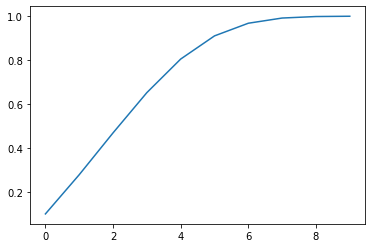

In [5]:
plt.plot(p)

In [24]:
points = np.array([[0, 0]])

for i in range(10):
    
    t = np.linspace(0, 2 * np.pi, 5*(i+1)**2, endpoint=False)
    tmp = np.stack((np.cos(t), np.sin(t))).T * p[i]
    
    points = np.concatenate([points, tmp])

### Run triangulation

In [25]:
cndt = triangulate({"vertices": points}, opts="Dneo1")
points = cndt["vertices"]
triangles = cndt["triangles"]
neighbours = cndt["neighbors"]
vertice_maker_is_boundary = cndt["vertex_markers"]
print(f"Total number of points {points.shape[0]}")

Total number of points 2926


### Visualize the triangulation

100%|██████████████████████████████████████████████████████████████| 4350/4350 [00:02<00:00, 1868.18it/s]


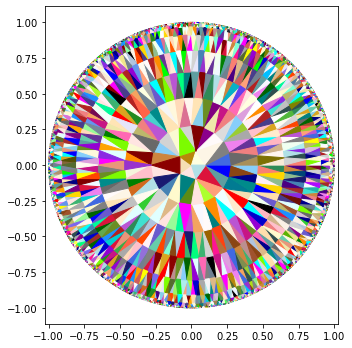

In [26]:
all_colors = (
    100 * list(mcolors.CSS4_COLORS.keys())
    + list(mcolors.XKCD_COLORS.keys())
    + list(mcolors.BASE_COLORS.keys())
)
colors = sample(all_colors, triangles.shape[0])

%matplotlib inline
fig, ax = plt.subplots(figsize=(5, 5))
ax.axis("equal")

for index, triangle in enumerate(tqdm(points[triangles])):
    t1 = plt.Polygon(triangle[:3], color=colors[index])
    fig.gca().add_patch(t1)
    x, y = triangle.mean(axis=0)

ax.set_xlim([points[:, 0].min(), points[:, 0].max()])
ax.set_ylim([points[:, 1].min(), points[:, 1].max()])

fig.tight_layout()
plt.show()

In [27]:
x, y = sympy.symbols("x y")

In [28]:
right_part_values = np.zeros((points.shape[0], 3))

In [29]:
F = sympy.Float(1)
F_x = F.diff(x)
F_y = F.diff(y)

In [30]:
right_part_values[:, 0] = sympy.lambdify((x, y), F)(*points.T)
right_part_values[:, 1] = sympy.lambdify((x, y), F_x)(*points.T)
right_part_values[:, 2] = sympy.lambdify((x, y), F_y)(*points.T)

In [ ]:
matrix = np.zeros((3 * points.shape[0], 3 * points.shape[0]))
b = np.zeros(3 * points.shape[0])

for idx, element in enumerate(tqdm(triangles)):
    x1, x2, x3 = points[element[0], 0], points[element[1], 0], points[element[2], 0]
    y1, y2, y3 = points[element[0], 1], points[element[1], 1], points[element[2], 1]

    delta = x1 * y2 - x1 * y3 - x2 * y1 + x2 * y3 + x3 * y1 - x3 * y2

    P_1_x = (+y2 - y3) / delta
    P_1_y = (-x2 + x3) / delta

    P_2_x = (+y3 - y1) / delta
    P_2_y = (-x3 + x1) / delta

    arg = [P_1_x, P_1_y, P_2_x, P_2_y]
    right = right_part_values[element].flatten()

    FF = poisson_finctional(*arg, *right)
    ff = integral_values(*arg, *right)

    for local_point in range(3):
        if vertice_maker_is_boundary[element[local_point]] == True and ((points[element[local_point]]**2).sum() > 0.1):
            matrix[3 * element[local_point] + 0, 3 * element[local_point] + 0] = 1

            for degree in range(1, 3):
                for other_point in range(3):
                    for other_degree in range(3):
                        matrix[
                            3 * element[local_point] + degree,
                            3 * element[other_point] + other_degree,
                        ] += (
                            2
                            * FF[
                                3 * local_point + degree, 3 * other_point + other_degree
                            ]
                        )

            b[3 * element[local_point] + 0] = 0
            b[3 * element[local_point] + 1] -= 2 * ff[3 * local_point + 1]
            b[3 * element[local_point] + 2] -= 2 * ff[3 * local_point + 2]

        else:
            for degree in range(3):
                for other_point in range(3):
                    for other_degree in range(3):
                        matrix[
                            3 * element[local_point] + degree,
                            3 * element[other_point] + other_degree,
                        ] += (
                            2
                            * FF[
                                3 * local_point + degree, 3 * other_point + other_degree
                            ]
                        )

            b[3 * element[local_point] + 0] -= 2 * ff[3 * local_point + 0]
            b[3 * element[local_point] + 1] -= 2 * ff[3 * local_point + 1]
            b[3 * element[local_point] + 2] -= 2 * ff[3 * local_point + 2]

 46%|█████████████████████████████                                  | 2011/4350 [00:03<00:03, 633.97it/s]

In [ ]:
c = np.linalg.solve(matrix, b)

In [ ]:
U = -(1-x**2-y**2)/4
U_x = sympy.lambdify((x, y), U.diff(x))(*points.T)
U_y = sympy.lambdify((x, y), U.diff(y))(*points.T)
U = sympy.lambdify((x, y), U)(*points.T)

In [ ]:
%matplotlib widget
fig = plt.figure(figsize=(9, 9))
ax = plt.axes(projection="3d")
orig = (points[:, 0] ** 2 + points[:, 1] ** 2 - 1) / 4

F_approx =   c[0::3]
F_x_approx = c[1::3]
F_y_approx = c[2::3]

ax.plot_trisurf(
    points[:, 0],
    points[:, 1],
    F_approx,
    cmap="magma",
    triangles=triangles
)

plt.show()

In [ ]:
abs(U-F_approx).max()/abs(F_approx).max()

In [ ]:
abs(U_x-F_x_approx).max()/abs(F_x_approx).max()

In [ ]:
abs(U_y-F_y_approx).max()/abs(F_y_approx).max()